# ICON Grid Plots

In [1]:
import netCDF4 as nc

In [8]:
import eccodes as ecc
import datetime
import numpy as np
import matplotlib.tri as mtri

In [61]:
# ICON Grid File
gridfile="icon_grid_0043_R02B04_G.nc"
print('Reading grid file:        ', gridfile)

with nc.Dataset(gridfile) as f:
    #vlon and vlat in ICON grid file are in radians
    vlon = f['vlon'][:] * 180/np.pi
    vlat = f['vlat'][:] * 180/np.pi
    vertex_of_cell = f['vertex_of_cell'][:]
    clat = f['clat'][:]
    # vertex indices in grid file count from 1, Python wants 0
    vertex_of_cell = vertex_of_cell - 1
    triangulation = mtri.Triangulation(vlon, vlat, vertex_of_cell.T)

print(vlon.shape, vlat.shape, clat.shape, vertex_of_cell.shape)

Reading grid file:         icon_grid_0043_R02B04_G.nc
(10242,) (10242,) (20480,) (3, 20480)


In [13]:
import matplotlib.pyplot as plt

# Suppose this is your triangulation object
tri = triangulation

# Print the first 10 triangle vertex indices
print("First 10 triangles (vertex indices):")
print(tri.triangles[:10])

# Optionally, show coordinates of those vertices
for i, triangle in enumerate(tri.triangles[:10]):
    coords = [(tri.x[v], tri.y[v]) for v in triangle]
    print(f"Triangle {i}: {coords}")

First 10 triangles (vertex indices):
[[ 0  1  2]
 [ 0  3  1]
 [ 1  4  2]
 [ 2  5  0]
 [ 6  7  0]
 [ 0  5  6]
 [ 6  8  7]
 [ 7  3  0]
 [ 9 10  1]
 [ 1  3  9]]
Triangle 0: [(74.83419899490596, 53.238727058348104), (71.16580100509405, 53.238727058348104), (73.0, 51.35016720343732)]
Triangle 1: [(74.83419899490596, 53.238727058348104), (73.00000000000001, 55.137843622674396), (71.16580100509405, 53.238727058348104)]
Triangle 2: [(71.16580100509405, 53.238727058348104), (69.5113043211856, 51.306370845366516), (73.0, 51.35016720343732)]
Triangle 3: [(73.0, 51.35016720343732), (76.4886956788144, 51.30637084536651), (74.83419899490596, 53.238727058348104)]
Triangle 4: [(78.49518375835214, 53.14409538418363), (76.8623138303842, 55.0865834475542), (74.83419899490596, 53.238727058348104)]
Triangle 5: [(74.83419899490596, 53.238727058348104), (76.4886956788144, 51.30637084536651), (78.49518375835214, 53.14409538418363)]
Triangle 6: [(78.49518375835214, 53.14409538418363), (80.70666062519544, 54.93

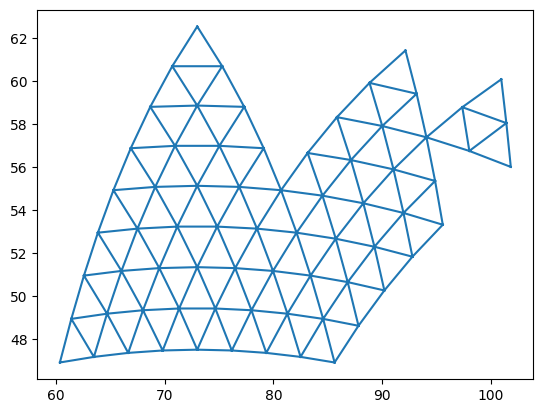

In [23]:
# Select the first n triangles from the triangulation
subset_tri = tri.triangles[:100]

# Create a new figure
plt.figure()

# Plot the selected triangles using line edges
plt.triplot(tri.x, tri.y, subset_tri)

In [36]:
valfile="fc_R02B04.2022010100"
import eccodes

def show_shortnames(grib_file):
    """Lists short names, levels, and sizes from a GRIB file."""
    with open(grib_file, 'rb') as f:
        shortName_prev = ''
        output = ''
        level_prev = ''
        count = 0
        print('-' * 80)
        print('File = ', grib_file)
        print('\n{:<30}{:<16}{:>10}'.format('Short Name', 'Level', 'Size'))
        print('-' * 80)
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            shortName = eccodes.codes_get(gid, "shortName")
            level = eccodes.codes_get(gid, "level")
            size1 = eccodes.codes_get_size(gid, "values")
            if shortName_prev != shortName:
                if level_prev != level and count > 0:
                    output += f' - {level_prev}'
                if count > 0:
                    output += f', \t Size = {size1}'
                output += '\n{:<30}{:<16}{:>10}'.format(shortName, level, size1)
                shortName_prev = shortName
                level_prev = level
                count += 1
            eccodes.codes_release(gid)
        print(output)

# Example usage
show_shortnames(valfile)

--------------------------------------------------------------------------------
File =  fc_R02B04.2022010100

Short Name                    Level                 Size
--------------------------------------------------------------------------------

VN                            1                    30720, 	 Size = 20480
wz                            1                    20480, 	 Size = 20480
den                           1                    20480, 	 Size = 20480
vptmp                         1                    20480, 	 Size = 20480
q                             1                    20480, 	 Size = 20480
clwmr                         1                    20480, 	 Size = 20480
QI                            1                    20480, 	 Size = 20480
rwmr                          1                    20480, 	 Size = 20480
snmr                          1                    20480, 	 Size = 20480
tke                           1                    20480, 	 Size = 20480
u                   

In [76]:
import numpy as np
import matplotlib.tri as mtri


def fix_dateline_triangles(triangulation, values, mask_only=False):
    """Fix triangles crossing the date line.

    Triangles crossing the horizontal map boundary are plotted across
    the whole two-dimensional plane of the PlateCarree projection
    (eg. from -180 degrees to 180 degrees), while they should "wrap
    around the back". For the respective triangles on either side of
    the plot, the vertices beyond the date line - on thus on the
    opposite side of the plot - are re-set to a value on the same side
    and the triangle is duplicated on the other side.

    To visualize this effect, use mask_only=True. In this case, the
    triangles are not duplicated and the respective triangles are only
    masked and will not be plotted.

    (ideas taken from the ICON Model Tutorial 2019, section 9.3.3)

    Parameters
    ----------
    triangulation : Triangulation
        the triangulation to be fixed
    values : ndarray
        the values corresponding to the triangulation
    mask_only : bool, optional
        whether to mask the triangles without changing the vertices

    Returns
    -------
    triangulation_fixed : Triangulation
        the triangulation with modified triangles and vertices
    values_fixed : ndarray
        the values with duplicated values for duplicated triangles appended

    """

    to_fix = np.argwhere(triangulation.x[triangulation.triangles].max(axis=1)
                         - triangulation.x[triangulation.triangles].min(axis=1)
                         > 200
                         )[:, 0]

    # create a new Triangulation object to avoid overwriting the original data
    triangulation_fixed = mtri.Triangulation(triangulation.x, triangulation.y, triangulation.triangles)

    if mask_only:
        triangulation_fixed.mask = np.full(triangulation.triangles.shape[0], False)
        triangulation_fixed.mask[to_fix] = True
    else:
        values_fixed = values.copy()
        k = triangulation.x.shape[0]
        for i in to_fix:
            # append the mirrored triangle and its value to the existing triangles and values
            triangle = triangulation.triangles[i]
            triangulation_fixed.triangles = np.vstack([triangulation_fixed.triangles, triangle])
            values_fixed = np.append(values_fixed, values[i])

            # adjust the vertices of the appended triangle such that all lon values are > 0
            idx_vertex = np.argwhere(triangulation.x[triangle]<0)
            for j in idx_vertex:
                triangulation_fixed.x = np.append(triangulation_fixed.x,
                                                  triangulation.x[triangle[j]] + 360)
                triangulation_fixed.y = np.append(triangulation_fixed.y,
                                                  triangulation.y[triangle[j]])
                triangulation_fixed.triangles[-1, j] = k
                k = k+1

            # adjust the vertices of the original, copied triangle such that all lon values are < 0
            idx_vertex = np.argwhere(triangulation.x[triangle]>0)
            for j in idx_vertex:
                triangulation_fixed.x = np.append(triangulation_fixed.x,
                                                  triangulation.x[triangle[j]] - 360)
                triangulation_fixed.y = np.append(triangulation_fixed.y,
                                                  triangulation.y[triangle[j]])
                triangulation_fixed.triangles[i, j] = k
                k = k+1

    return triangulation_fixed, values_fixed


In [88]:
def extract_values(grib_file, sname):
    with open(grib_file, 'rb') as f:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break  # End of file

            short_name = eccodes.codes_get(gid, "shortName")
            if short_name == sname:
                values = eccodes.codes_get_array(gid, "values")
                eccodes.codes_release(gid)
                return values

            eccodes.codes_release(gid)
    
    raise ValueError(f"shortName '{sname}' not found in {grib_file}")

#values1=extract_values(valfile,"T_G")
values1=extract_values(valfile,"lsm")

triangulation2, values2 = fix_dateline_triangles(triangulation, values1, False)

print(values1.shape,values2.shape,triangulation.triangles.shape,triangulation2.triangles.shape)

(20480,) (20670,) (20480, 3) (20670, 3)


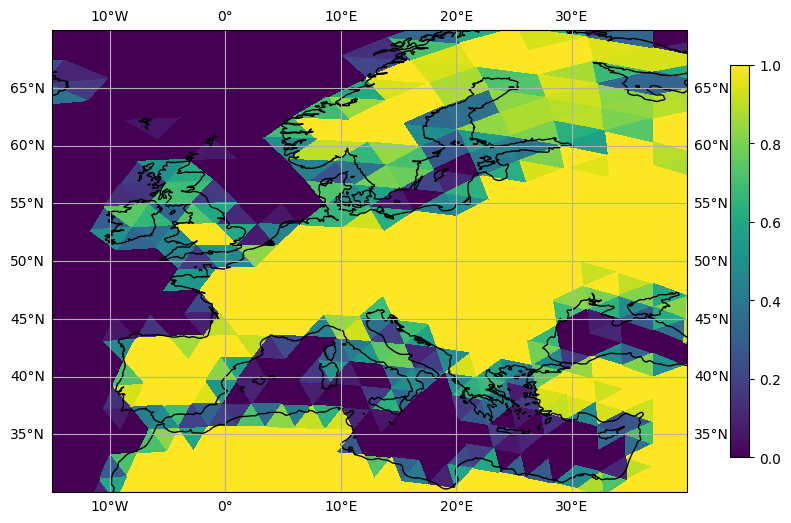

In [91]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

varmin = min(values2)
varmax = max(values2)

fig, ax = plt.subplots(figsize=(11,6), subplot_kw=dict(projection=ccrs.PlateCarree()))
map = ax.tripcolor(triangulation2, values2, cmap='viridis', vmin=varmin, vmax=varmax)
ax.coastlines()     # requires HTTPS_PROXY=http://ofsquid.dwd.de:8080 for internet - and PlateCarree
gl = ax.gridlines(draw_labels=True)
cbar = plt.colorbar(map, shrink=0.85)

# Europe
ax.set_extent([-15, 40, 30, 70], crs=ccrs.PlateCarree())
# Central America
#ax.set_extent([-100, -75, 5, 25], crs=ccrs.PlateCarree())
